In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from scipy.integrate import solve_ivp, quad
from scipy.optimize import fsolve
from scipy.spatial.distance import pdist, squareform

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
class MonteCarloSystem:
    def __init__(self, calc, x0=0, kT=0.15, xmin=-3, xmax=3, transition_method='delta', Nsim=1000, delta=0.1):
        self.calc = calc
        self.x0 = x0
        self.sample = None
        self._kT = kT
        self.xmin = xmin
        self.xmax = xmax
        assert transition_method in ['delta', 'uniform'], "transition_method must be 'delta' or 'uniform'"
        self.transition_method = transition_method
        self.Nsim = Nsim
        self.delta = delta
    
    @property
    def kT(self):
        return self._kT
    
    @kT.setter
    def kT(self, value):
        if self._kT != value:
            self.sample = None
            self._kT = value
    
    def direct_integration(self, property_=None):
        if property_ is None:
            property_ = self.calc.potential_energy
        numerator_inner = lambda x: property_(x) * np.exp(-property_(x) / self._kT)
        denominator_inner = lambda x: np.exp(-self.calc.potential_energy(x) / self._kT)
        numerator, _ = quad(numerator_inner, -np.inf, np.inf)
        denominator, _ = quad(denominator_inner, -np.inf, np.inf)
        return numerator / denominator
    
    def estimate_from_sample(self, property_=None):
        if property_ is None:
            property_ = self.calc.potential_energy
        if self.sample is None:
            self.setup_sample()
        numerator = np.sum(property_(self.sample))
        denominator = len(self.sample)
        return numerator / denominator
    
    def setup_sample(self):
        xs = []
        x = self.x0
        for e in range(self.Nsim):
            xs.append(x)
            if self.transition_method == 'delta':
                x_new = x + self.delta * np.random.randn()
            else:
                x_new = self.xmin + (self.xmax - self.xmin) * np.random.rand()
            de = self.calc.potential_energy(x_new) - self.calc.potential_energy(x)
            if np.random.rand() < np.exp(-de / self._kT):
                x = x_new
        self.sample = np.array(xs)

        print(f'Sample size: {len(self.sample)}')
    
    def plot_sample(self, ax, xwidth=0.1, bins=100):
        # Plot potential
        xs = np.linspace(self.xmin, self.xmax, 1000)
        ax.plot(xs, self.calc.potential_energy(xs), label='Potential energy', c='tab:orange')

        # Plot distribution
        if self.sample is None:
            self.setup_sample()
        xs = np.arange(self.xmin, self.xmax, xwidth)
        bars, xs = np.histogram(self.sample, bins=xs, density=True)

        xvals = (xs[:-1] + xs[1:]) / 2
        delta_xvals = xvals[1] - xvals[0]
        P = bars / np.sum(bars) / delta_xvals
        width = delta_xvals * 0.8
        ax.bar(xvals, 0.5*P, width=width, label='Sample distribution', color='tab:blue')

        average_V_exact = self.direct_integration()
        average_V_sample = self.estimate_from_sample()
        ax.set_title(fr'$\langle V \rangle_{{\text{{exact}}}} = {average_V_exact:.3f}$, $\langle V \rangle_{{\text{{MC}}}} = {average_V_sample:.3f}$')
        ax.text(0.5, 0.5, fr'$kT = {self._kT}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

In [3]:
def velocity_verlet(mass, N=100, dt=0.01):
    rs = []
    for _ in range(N):
        r = mass.get_position()
        v = mass.get_velocity()
        a_t = mass.force()
        r += v * dt + 0.5 * a_t * dt**2
        mass.set_position(r)
        a_t_dt = mass.force()
        v += 0.5 * (a_t + a_t_dt) * dt
        mass.set_velocity(v)
        rs.append(r)
    return rs

In [4]:
class MolDynSystem:
    def __init__(self, calc, m=1, x=0, kT=0.15, xmin=-3, xmax=3, sample_size=2000, verlet_steps=500):
        self.calc = calc
        self.m = m
        self.x = x
        self.v = 0
        self._kT = kT
        self.xmin = xmin
        self.xmax = xmax
        self.sample = None
        self.sample_size = sample_size
        self.verlet_steps = verlet_steps
    
    @property
    def kT(self):
        return self._kT
    
    @kT.setter
    def kT(self, value):
        if self._kT != value:
            self.sample = None
            self._kT = value
    
    def potential_energy(self):
        return self.calc.potential_energy(self.x)
    
    def force(self):
        return self.calc.force(self.x)
    
    def get_position(self):
        return self.x
    
    def set_position(self, x):
        self.x = x
    
    def get_velocity(self):
        return self.v
    
    def set_velocity(self, v):
        self.v = v
    
    def setup_sample(self):
        if self.sample is None:
            self.sample = []
        for _ in range(self.sample_size):
            r = velocity_verlet(self, N=self.verlet_steps)
            self.sample.append(r[-1])
            andrea_anderson_thermostat(self)
    
    def plot(self, ax, xwidth=0.1):
        # Plot potential
        xs = np.linspace(self.xmin, self.xmax, 1000)
        ax.plot(xs, self.calc.potential_energy(xs), label='Potential energy', c='tab:orange')

        # Plot distribution
        if self.sample is None:
            self.setup_sample()
        xs = np.arange(self.xmin, self.xmax, xwidth)
        bars, xs = np.histogram(self.sample, bins=xs, density=True)

        xvals = (xs[:-1] + xs[1:]) / 2
        delta_xvals = xvals[1] - xvals[0]
        P = bars / np.sum(bars) / delta_xvals
        width = delta_xvals * 0.8
        ax.bar(xvals, 0.5*P, width=width, label='Sample distribution', color='tab:blue')

        v_pot_ave = np.mean([self.calc.potential_energy(r) for r in self.sample])
        ax.set_title(fr'$\langle V \rangle = {v_pot_ave:.3f}$')

        ax.text(0.5, 0.5, fr'$kT = {self._kT}$', transform=ax.transAxes, fontsize=12,
            verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

In [5]:
def andrea_anderson_thermostat(md):
    v = md.kT**0.5 * np.random.randn()
    md.set_velocity(v)

In [6]:
class DoubleWell:
    def __init__(self, A=-1, k=1, x0=0, x1=1.5, lambda_=0.25):
        self.A = A
        self.k = k
        self.x0 = x0
        self.x1 = x1
        self.lambda_ = lambda_
    
    def potential_energy(self, x):
        return 0.5*self.k*(x-self.x0)**2 + self.A*np.exp(-(x-self.x1)**2/self.lambda_**2)
    
    def force(self, x):
        return -self.k*(x-self.x0) + 2*self.A*(x-self.x1)*np.exp(-(x-self.x1)**2/self.lambda_**2)/self.lambda_**2

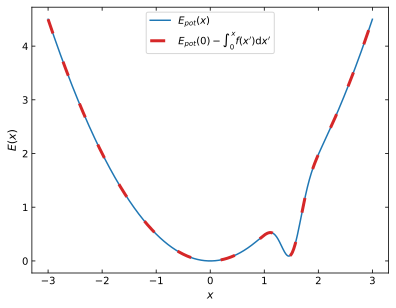

In [7]:
dw = DoubleWell()
xs = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
ax.plot(xs, dw.potential_energy(xs), label=fr'$E_{{pot}}(x)$')

e = lambda x: quad(lambda x: -dw.force(x), 0, x)[0]
xs = np.linspace(-3, 3, 500)
ax.plot(xs, [e(x) for x in xs], 'C3', linestyle=(0, (5, 10)), lw=3, label=fr"$E_{{pot}}(0) - \int_0^x f(x')\text{{d}}x'$")
ax.set(xlabel=r'$x$', ylabel=r'$E(x)$')
ax.legend()

fig.savefig('ex25_fig1.png')

### Metropolis Monte Carlo
Perform direct integration and Metropolis Monte Carlo estimation of the thermally averaged potential energy of this oscillator. Also, plot the distribution probability function. Repeat for some different temperatures.

Sample size: 10000
Sample size: 10000
Sample size: 10000
Sample size: 10000


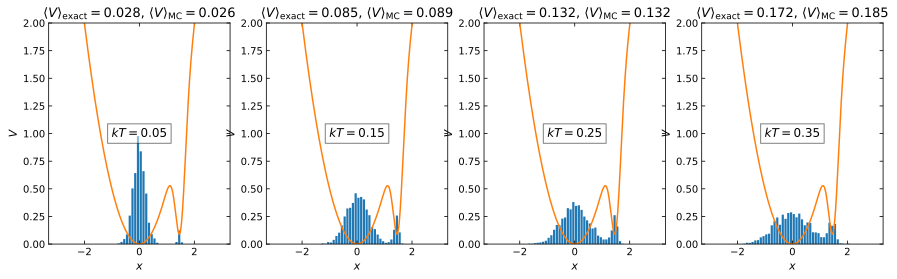

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
system = MonteCarloSystem(dw, Nsim=10000, transition_method='uniform')
kTs = [0.05, 0.15, 0.25, 0.35]
for ax, kT in zip(axs, kTs):
    system.kT = kT
    system.plot_sample(ax)
    ax.set(xlabel=r'$x$', ylabel=r'$V$', ylim=[0, 2])

fig.savefig('ex25_fig2.png')

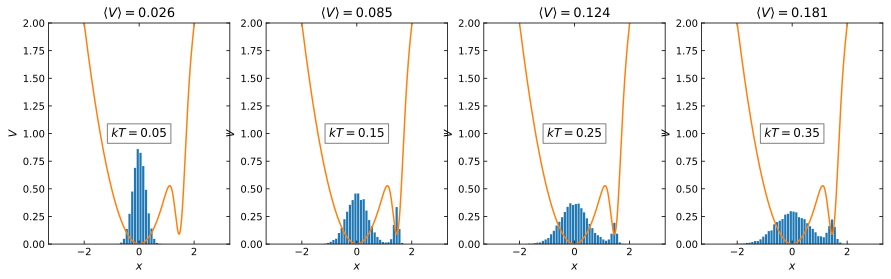

In [9]:
md = MolDynSystem(dw, x=0, sample_size=10000, verlet_steps=50)
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
kTs = [0.05, 0.15, 0.25, 0.35]
for ax, kT in zip(axs, kTs):
    md.kT = kT
    md.plot(ax)
    ax.set(xlabel=r'$x$', ylabel=r'$V$', ylim=[0, 2])

fig.savefig('ex25_fig3.png')

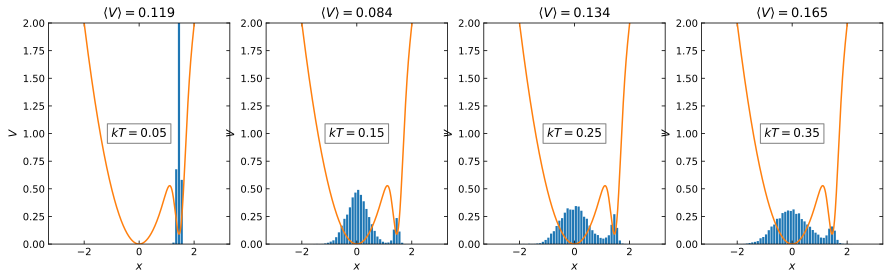

In [10]:
md = MolDynSystem(dw, x=1.5, sample_size=10000, verlet_steps=50)
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
kTs = [0.05, 0.15, 0.25, 0.35]
for ax, kT in zip(axs, kTs):
    md.kT = kT
    md.plot(ax)
    ax.set(xlabel=r'$x$', ylabel=r'$V$', ylim=[0, 2])

fig.savefig('ex25_fig4.png')